# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [163]:
#Librerias

from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [164]:
#Proporcionamos una URL

URL = "https://ycharts.com/companies/TSLA/revenues"

In [165]:
def DataSeeker(get_url):
    driver = webdriver.Chrome()
    driver.get(get_url)

    #Obtenemos el HTML
    raw_data = driver.find_elements(By.TAG_NAME, "tr")

    #Limpiamos los datos

    data = []
    for i in raw_data:
        data.append(i.text)
        if ("General" in str(i.text)):
            data.remove(i.text)
            break
        elif ("Date" in str(i.text)):
            data.remove(i.text)

    #Cerramos conexion
    driver.quit()
    return data

In [224]:
def SplitData(data):
    #Separamos los valores que queremos ingresar al DataFrame
    split_date = []
    date = []
    str_revenue = []
    flt_revenue = []
    year = []
    for i in range(len(data)):
        str_revenue.append (data[i].split(" ")[-1])
        split_date.append(data[i].split(" ")[:3])
        year.append(split_date[i][-1])
        date.append(split_date[i][0]) #Cogemos solo el mes porque considero que el dia es un dato irrelevante al tomarse siempre los datos el último día del mes.
    

    
    #Convertir los valores str en float
    for s in str_revenue:
        if ("B" in str(s)):
            s = float(s.replace("B",""))
            flt_revenue.append(s*1000)
        elif ("M" in str(s)):
            s = float(s.replace("M", ""))
            flt_revenue.append(s)

    
    return date, year, flt_revenue

In [225]:
def TransformDataSet(col1, col2, col3):
    #Creamos el Data Set
    dataset = pd.DataFrame(zip(col1, col2, col3), columns=["Date","Year","Revenue"])

    #Eliminamos las dos primeras filas innecesarias.
    dataset = dataset.drop([0,1,2,3,4,5,6]).reset_index(drop = True)

    return dataset

In [310]:
def SaveIntoDB(dataset):
    # Nos conectamos a la base de datos

    con = sqlite3.connect("tesla.db")

    #Importamos los datos del Dataset a la base de datos
    dataset.to_sql(name=("tesla_quaterly_revenue"), con = con, if_exists="replace")

    con.commit()
    
    return f"Database is uploaded."



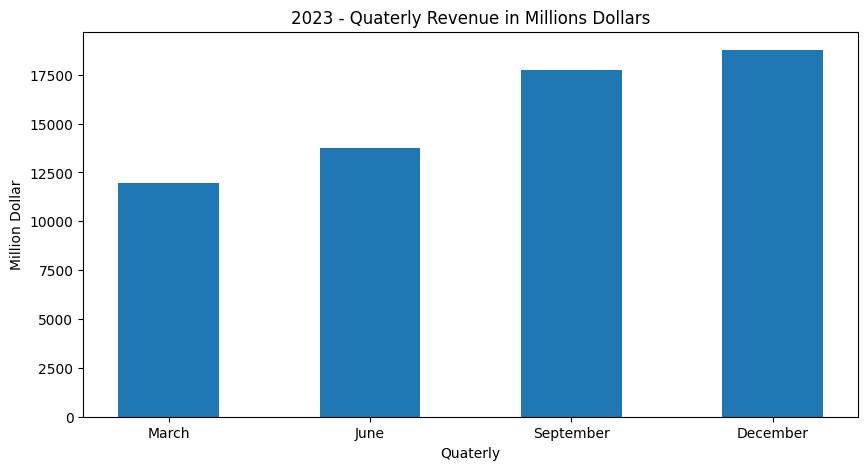

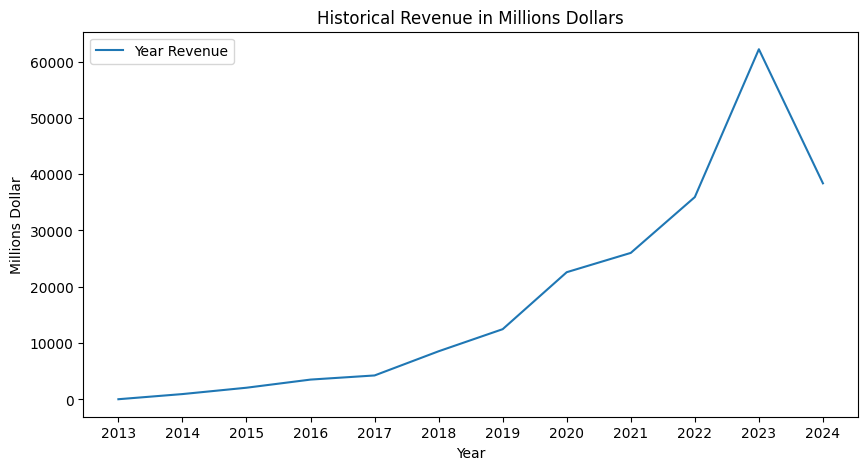

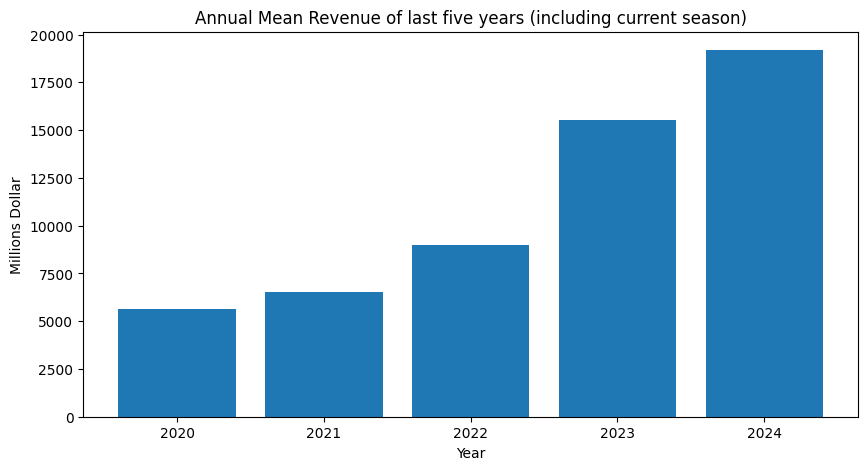

,Year,Anual_Revenue
0,2020,5648.25
1,2021,6505.50
2,2022,8984.25
3,2023,15550.00
4,2024,19190.00


In [322]:
#Visualizacion de datos

#Beneficios trimestrales del año pasado.
def RevenueYear():

    con = sqlite3.connect("tesla.db")
    data = pd.read_sql('SELECT tesla.date, tesla.revenue FROM tesla_quaterly_revenue AS tesla WHERE tesla.year = "2023" ORDER BY tesla.revenue', con)
    
    plt.figure(figsize=(10,5))
    plt.bar(data["Date"], data["Revenue"], width= 0.5)
    plt.title("2023 - Quaterly Revenue in Millions Dollars")
    plt.xlabel("Quaterly")
    plt.ylabel("Million Dollar")
    plt.savefig("./grafics/2023-QuaterlyRevenue.png")
    plt.show()
    return data

#Evolucion de beneficios durante los años.
def EvoRevenue():

    con = sqlite3.connect("tesla.db")
    data = pd.read_sql('SELECT tesla.year, SUM(tesla.revenue) AS Year_Revenue FROM tesla_quaterly_revenue AS tesla GROUP BY tesla.year;', con)

    plt.figure(figsize=(10,5))
    plt.plot(data["Year"], data["Year_Revenue"], label = "Year Revenue")
    plt.title("Historical Revenue in Millions Dollars")
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel("Millions Dollar")
    plt.savefig("./grafics/Histoical-Revenue.png")
    plt.show()

#Comparativa de la media anual de los últimos 5 años.
def LastFiveYearsRevenue():

    con = sqlite3.connect("tesla.db")
    data = pd.read_sql('SELECT tesla.year, AVG(tesla.revenue) AS Anual_Revenue FROM tesla_quaterly_revenue AS tesla GROUP BY tesla.year ORDER BY tesla.year LIMIT 5 OFFSET 7;', con)

    plt.figure(figsize=(10,5))
    plt.bar(data["Year"], data["Anual_Revenue"])
    plt.title("Annual Mean Revenue of last five years (including current season)")
    plt.xlabel("Year")
    plt.ylabel("Millions Dollar")
    plt.savefig("./grafics/Mean-Revenue.png")
    plt.show()

In [311]:
#Ejecutamos las funciones

date, year, revenue = SplitData(DataSeeker(URL))
SaveIntoDB(TransformDataSet(date, year, revenue))


'Database is uploaded.'

In [ ]:
#Graficamos los datos

RevenueYear()
EvoRevenue()
LastFiveYearsRevenue()